# Magic Hands
---

In this project, we are going to work on our first Deep Learning project where we are going to train a Deep Neural Network to recognize your hand patterns. This can be used to create a simple game or control system where based on the detected pattern, you can execute a certain script that will perform some gesture-specific action.

We are using the Tensorflow framework for this project.

## Importing Project Dependencies
---

As the first step of this project, we are going to import all the necessary project dependencies.

In [1]:
# perform OS related operations
import os

# dependencies for model training and data handling
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# dependencies for working with images
import PIL
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Preprocessing Data
---

Now, if you look at the images in the dataset, you will notice two things.
* The dimensions for the images are different.
* The images are rectangular in shape.

Working with consistent data is easier than working with data that is inconsistent. We need to make all the items within our dataset consistent, because our model is going to expect an input of the same size and not varying size.

So for the preprocessing, we are going to perform a center crop on all the images within the dataset, and make all the images of the same dimension.

First, we will perform the center crop on all the images to make them square.

In [2]:
# getting data directories for different labels

data_dir = os.path.join(os.getcwd(), "data")
label_dir = [os.path.join(data_dir, label) for label in os.listdir(data_dir) if not label.startswith('.')]
label_dir

['/Users/amansharma2910/projects/magic_hands/data/0',
 '/Users/amansharma2910/projects/magic_hands/data/1',
 '/Users/amansharma2910/projects/magic_hands/data/2']

In [3]:
# defining function to square center crop all the images in a directory

def square_crop_images(dir: str) -> None:
    images = [os.path.join(dir, image) for image in os.listdir(dir) if (image.endswith(".jpg") and not image.startswith("."))]
    for img in images:
        im = PIL.Image.open(img)
        
        width, height = im.size
        size = min(width, height)
        
        left = (width - size)/2
        top = (height - size)/2
        right = (width + size)/2
        bottom = (height + size)/2

        # crop the center of the image
        im = im.crop((left, top, right, bottom))

        # save image
        im.save(img)

In [4]:
# performing center crop on the dataset images

for dir in label_dir:
    square_crop_images(dir)

Now, we have square cropped the images. We need not resize them now. The images will be automatically resized as we load them into a Tensorflow compatible dataset.

## Loading Dataset
---

The next step is loading our dataset into a Tensorflow compatible dataset format, so we can finally begin training our deep learning model.

For this, we are going to use the `image_dataset_from_directory` util method defined provided by Tensorflow. You can refer to the docs for the same here: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory 

In [5]:
img_size = 256
batch_size = 8

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode="int",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 600 files belonging to 3 classes.
Using 480 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode="int",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 600 files belonging to 3 classes.
Using 120 files for validation.


We have created the datasets. What this function basically does is, it converts each image into a tensor as it loads it, and associates a label with it. Let us verify that the dataset is working as intended.

In [8]:
for batch in train_ds:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

2022-11-26 00:26:41.849347: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(8, 256, 256, 3)
(8,)


The following are the class names respectively for the images in the dataset.

In [9]:
train_ds.class_names

['0', '1', '2']

With this, our images are loaded. Now let us visualize our dataset.

## Visualizing the Data
---

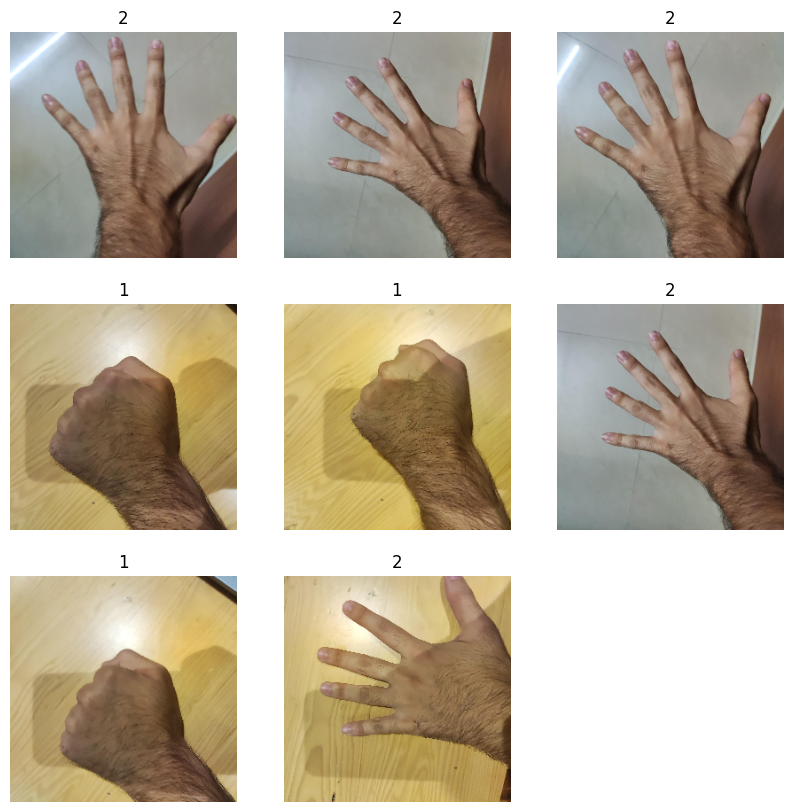

In [10]:
# plot the images in the first batch of the dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

## Standardizing the Data
---

Now, in the images that we are using in our dataset, each RGB pixel has a value ranging from [0,255]. This is not ideal for our DNN as more data values mean the DNN has to "learn" more. For this, we would require A LOT of data. Even then, the accuracy of the model would not be that good. So we need to standardize the values in the dataset to a much smaller range, like [0,1]. 

Now, you need not write any special code in order to do this. Since this is a common problem while working with image datasets, Tensorflow has pre-defined solutions for this, which we are going to use while defining our Deep Neural Network model.

But first, just to understand the problem discussed above, let us take a look at the pixel values for the first image in our dataset.

In [11]:
# fetch the first image in the first batch of data
for images, labels in train_ds.take(1):
    image = images[0].numpy()
    break

image

array([[[214.23022 , 199.23022 , 160.23022 ],
        [211.07812 , 196.07812 , 157.07812 ],
        [218.      , 203.      , 164.      ],
        ...,
        [ 22.640625,  27.713623,  30.494629],
        [ 19.      ,  26.      ,  34.      ],
        [ 16.359375,  21.359375,  24.359375]],

       [[214.      , 199.      , 160.      ],
        [214.15015 , 198.15015 , 162.15015 ],
        [221.98413 , 205.98413 , 169.98413 ],
        ...,
        [ 59.73462 ,  66.43823 ,  85.62549 ],
        [ 31.709229,  43.39673 ,  59.631104],
        [ 23.459473,  31.381348,  33.693848]],

       [[210.      , 195.      , 156.      ],
        [216.28125 , 200.28125 , 164.28125 ],
        [220.79688 , 204.79688 , 168.79688 ],
        ...,
        [140.90503 , 168.74316 , 182.49878 ],
        [ 98.51489 , 126.10864 , 138.31177 ],
        [ 60.703125,  72.5     ,  87.3125  ]],

       ...,

       [[165.79688 , 147.79688 ,  85.796875],
        [168.54663 , 149.54663 ,  93.54663 ],
        [172.79688 , 1

As you can see, each value (denoting a single pixel in the image) is in the range [0, 255].

## Training Your First Model
---

Now that you are done with some basic pre-processing and visualization of the dataset, we are going to train our first model.

In [12]:

num_classes = len(train_ds.class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Now, let us compile our model. We are going to use `ADAM` optimizer for this tutorial, and sparse categorical cross entropy loss algorithm for calculation of loss.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Finally, let us take a look at the summary of the model that we have defined.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

Finally, let us train our model. We are going to train the model for 10 epochs, and see how it fares.

In [15]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 [==============================] - 9s 139ms/step - loss: 1.0626 - accuracy: 0.5625 - val_loss: 0.2863 - val_accuracy: 0.9000
Epoch 2/10
60/60 [==============================] - 9s 137ms/step - loss: 0.0769 - accuracy: 0.9771 - val_loss: 6.6980e-04 - val_accuracy: 1.0000
Epoch 3/10
60/60 [==============================] - 9s 141ms/step - loss: 0.0349 - accuracy: 0.9875 - val_loss: 0.0406 - val_accuracy: 0.9833
Epoch 4/10
60/60 [==============================] - 9s 137ms/step - loss: 0.0149 - accuracy: 0.9979 - val_loss: 3.4870e-05 - val_accuracy: 1.0000
Epoch 5/10
60/60 [==============================] - 9s 149ms/step - loss: 1.2130e-04 - accuracy: 1.0000 - val_loss: 2.1522e-05 - val_accuracy: 1.0000
Epoch 6/10
60/60 [==============================] - 9s 143ms/step - loss: 3.7023e-05 - accuracy: 1.0000 - val_loss: 1.4995e-05 - val_accuracy: 1.0000
Epoch 7/10
60/60 [==============================] - 9s 140ms/step - loss: 2.9598e-05 - accuracy: 1.0000 - val_loss: 1.1692e-

## Visualizing the Results
---

Now that our model's training is done, let us visualize the results of the training process.

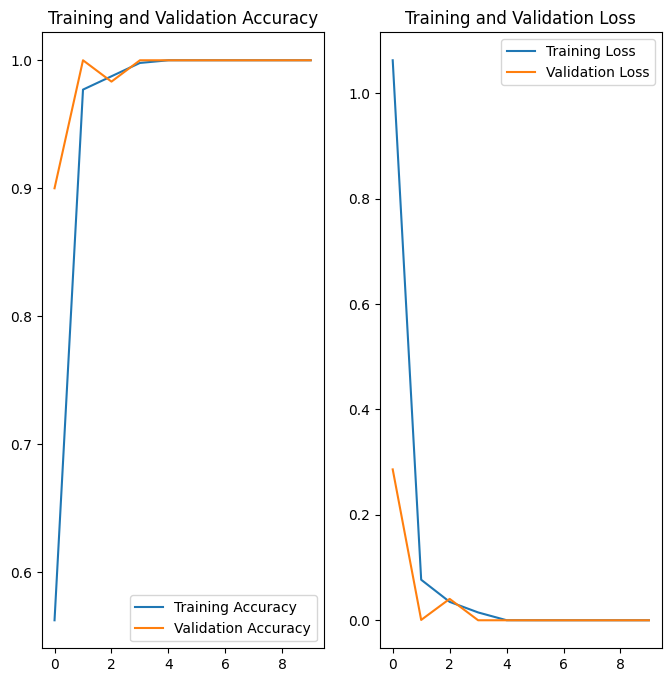

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving the Model
---

Finally, let us save the model so we can use it later for some fun little project.

In [17]:
work_dir = os.getcwd()
save_path = os.path.join(work_dir, "model")

model.save(save_path)

2022-11-26 00:28:15.114901: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/amansharma2910/projects/magic_hands/model/assets
